In [1]:
#! pip install pyLDAvis
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

with open("../data/all_reviews.pkl","rb") as f:
    reviews = pickle.load(f)
    
job_filter = pd.read_csv("../data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()

idx = reviews.clean_job_title.isin(job_filters)
reviews = reviews.loc[idx,:]

print( reviews.shape )
reviews.reset_index(drop=True,inplace=True)
display( reviews.head() )

(67031, 14)


,company_name,review_title,job_title,employee_status,location,date,review,pros,cons,rating,yes_helpful,no_helpful,industry,clean_job_title
0,EY,I had a great time working at EY,Software Developer,Former Employee,"Bengaluru, Karnataka",2020-03-02,Pros:\rGreat Learning Curve.\rPeer Culture is ...,NaN,NaN,4.0,0,0,accounting,software developer
1,EY,Great place to be,Office Administrator/Receptionist,Former Employee,Cork,2020-02-28,A lovely team and very pretty environment. I f...,NaN,NaN,5.0,0,0,accounting,office administrator receptionist
2,EY,Productive and FUN Place,System Engineer,Current Employee,"Hyderabad, Telangana",2020-02-25,It's feel like workplace where can utilize kno...,NaN,NaN,5.0,0,0,accounting,system engineer
3,EY,Fun to work at and has the best Work Culture,Associate Software Engineer,Former Employee,Bengaluru,2020-02-15,Supportive peers and leaders who are always pr...,NaN,NaN,5.0,0,0,accounting,associate software engineer
4,EY,Good Environment,Desktop Support Administrator & Business Opera...,Current Employee,"Nashville, TN",2020-01-24,EY is a very nice environment to work at. Tec...,NaN,NaN,4.0,0,0,accounting,desktop support administrator business operati...


In [2]:
#NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#extend stop word based on top 50 words
stop_words.extend(["new","lot","get","many","also","day","part","one","things","always","years","really"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\04616598\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [4]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [5]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [6]:
nltk.download('wordnet')
processed_docs = reviews['review'].map(prepare_text_for_lda)
processed_docs[:10]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\04616598\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [great, learning, curve, culture, great, balan...
1    [lovely, pretty, environment, welcome, great, ...
2    [workplace, utilize, knowledge, skill, managem...
3    [supportive, peer, leaders, present, guide, te...
4    [environment, tech, player, learn, something, ...
5    [company, management, excellent, working, bala...
6    [energetic, vibrant, company, extrovert, deali...
7    [place, learn, technology, culture, awesome, p...
8    [great, place, culture, flexible, hours, helpi...
9    [flexibility, management, employee, benefit, i...
Name: review, dtype: object

In [7]:
from gensim import corpora
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(text) for text in processed_docs]

In [8]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.105*"great" + 0.060*"place" + 0.056*"working" + 0.055*"people"')
(1, '0.043*"company" + 0.022*"employee" + 0.021*"would" + 0.020*"people"')
(2, '0.032*"business" + 0.027*"company" + 0.025*"services" + 0.020*"large"')
(3, '0.044*"management" + 0.033*"manager" + 0.019*"office" + 0.015*"level"')
(4, '0.057*"learn" + 0.046*"opportunity" + 0.039*"career" + 0.037*"company"')
(5, '0.083*"learn" + 0.055*"management" + 0.052*"worker" + 0.042*"working"')
(6, '0.038*"customer" + 0.018*"issue" + 0.017*"client" + 0.012*"daily"')
(7, '0.031*"mahindra" + 0.026*"shift" + 0.017*"situation" + 0.015*"night"')
(8, '0.066*"company" + 0.065*"employee" + 0.039*"balance" + 0.038*"management"')
(9, '0.029*"system" + 0.024*"software" + 0.021*"application" + 0.018*"development"')


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics = num_topics ,id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=2, limit=30, step=2)

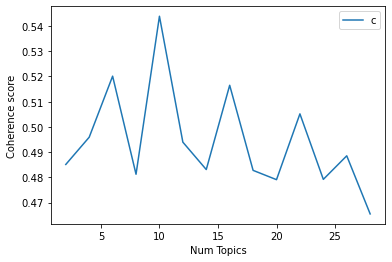

In [11]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4851
Num Topics = 4  has Coherence Value of 0.4959
Num Topics = 6  has Coherence Value of 0.5201
Num Topics = 8  has Coherence Value of 0.4812
Num Topics = 10  has Coherence Value of 0.5439
Num Topics = 12  has Coherence Value of 0.494
Num Topics = 14  has Coherence Value of 0.4831
Num Topics = 16  has Coherence Value of 0.5165
Num Topics = 18  has Coherence Value of 0.4828
Num Topics = 20  has Coherence Value of 0.4791
Num Topics = 22  has Coherence Value of 0.5052
Num Topics = 24  has Coherence Value of 0.4792
Num Topics = 26  has Coherence Value of 0.4885
Num Topics = 28  has Coherence Value of 0.4655


In [13]:
model_list

In [14]:
coherence_values

[0.4851106572517619,
 0.49590768026337717,
 0.5201165718145573,
 0.48122587500110675,
 0.5438713016012525,
 0.4939517114438092,
 0.48308669684985345,
 0.5165015155904716,
 0.4827642265310092,
 0.47907867704726403,
 0.5051664313289921,
 0.47919640879861464,
 0.48853691842044655,
 0.4654968665992865]

In [15]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.047*"customer" + 0.015*"service" + 0.012*"wipro" + 0.010*"call" + '
  '0.009*"mahindra" + 0.009*"office" + 0.008*"order" + 0.007*"client" + '
  '0.007*"account" + 0.007*"sales"'),
 (1,
  '0.102*"project" + 0.036*"technology" + 0.023*"genpact" + 0.023*"process" + '
  '0.021*"developer" + 0.019*"development" + 0.017*"software" + 0.016*"client" '
  '+ 0.013*"domain" + 0.013*"depend"'),
 (2,
  '0.058*"learn" + 0.038*"working" + 0.033*"worker" + 0.031*"management" + '
  '0.023*"enjoyable" + 0.021*"hard" + 0.019*"enjoy" + 0.015*"skill" + '
  '0.014*"environment" + 0.014*"typical"'),
 (3,
  '0.043*"company" + 0.021*"employee" + 0.019*"people" + 0.019*"management" + '
  '0.017*"great" + 0.013*"would" + 0.012*"manager" + 0.011*"place" + '
  '0.010*"change" + 0.009*"work"'),
 (4,
  '0.023*"system" + 0.017*"application" + 0.014*"business" + 0.013*"support" + '
  '0.013*"server" + 0.012*"software" + 0.012*"using" + 0.011*"requirement" + '
  '0.011*"testing" + 0.010*"create"'),
 (5,
  '0.

In [16]:
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)